In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [16]:
# XOR Dataset
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
], dtype=np.float32)

y = np.array([
    [0],
    [1],
    [1],
    [0]
], dtype=np.float32)


In [17]:
def plot_decision_boundary(predict_fn, title):
    xx, yy = np.meshgrid(
        np.linspace(-0.5, 1.5, 300),
        np.linspace(-0.5, 1.5, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    preds = predict_fn(grid).reshape(xx.shape)

    plt.contourf(xx, yy, preds, levels=50, cmap="RdBu", alpha=0.6)
    plt.scatter(X[:,0], X[:,1], c=y.flatten(), edgecolors='k')
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()


# XOR Using Keras

In [18]:
import tensorflow as tf


In [19]:
def build_keras_model(neurons, activation, optimizer, lr):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(neurons, activation=activation, input_shape=(2,)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    opt = tf.keras.optimizers.Adam(lr) if optimizer == "adam" \
          else tf.keras.optimizers.SGD(lr)

    model.compile(
        optimizer=opt,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [20]:
keras_results = []

for neurons in [2, 4, 8]:
    for lr in [0.001, 0.01]:
        model = build_keras_model(neurons, "tanh", "adam", lr)
        history = model.fit(X, y, epochs=300, verbose=0)
        keras_results.append([
            neurons, lr,
            history.history["loss"][-1],
            history.history["accuracy"][-1]
        ])

df_keras = pd.DataFrame(
    keras_results,
    columns=["Neurons", "Learning Rate", "Final Loss", "Final Accuracy"]
)

print(df_keras)


C:\Users\Varshitha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   Neurons  Learning Rate  Final Loss  Final Accuracy
0        2          0.001    0.727438             0.5
1        2          0.010    0.064110             1.0
2        4          0.001    0.622328             0.5
3        4          0.010    0.039633             1.0
4        8          0.001    0.584869             1.0
5        8          0.010    0.008698             1.0


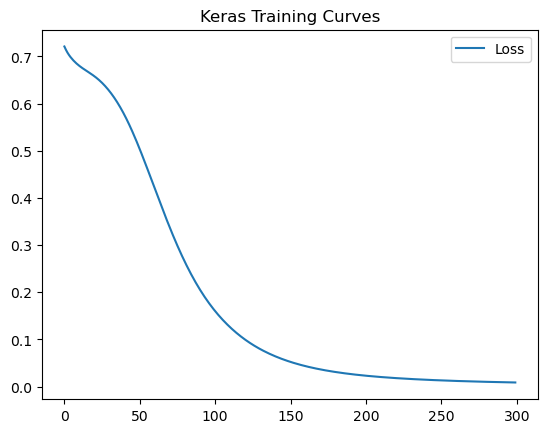

In [24]:
plt.plot(history.history["loss"], label="Loss")
plt.title("Keras Training Curves")
plt.legend()
plt.show()


In [22]:
print("Keras Predictions:")
print(np.round(model.predict(X)))


Keras Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
[[0.]
 [1.]
 [1.]
 [0.]]


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 3s 982us/step 


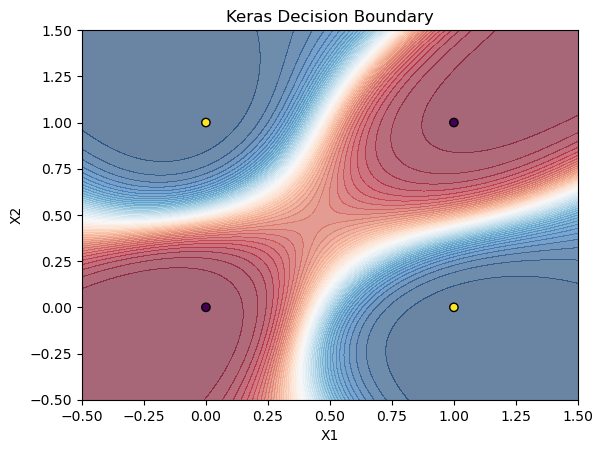

In [23]:
plot_decision_boundary(
    lambda x: model.predict(x),
    "Keras Decision Boundary"
)


# XOR Using Pytorch

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim


In [26]:
X_torch = torch.tensor(X)
y_torch = torch.tensor(y)


In [27]:
class XORNet(nn.Module):
    def __init__(self, neurons):
        super().__init__()
        self.fc1 = nn.Linear(2, neurons)
        self.fc2 = nn.Linear(neurons, 1)
        self.act = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act(self.fc1(x))
        return self.sigmoid(self.fc2(x))


In [28]:
def train_pytorch(neurons, lr, epochs):
    model = XORNet(neurons)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(X_torch)
        loss = criterion(y_pred, y_torch)
        loss.backward()
        optimizer.step()

        acc = ((y_pred >= 0.5) == y_torch).float().mean().item()
        history.append([epoch+1, loss.item(), acc])

    return model, pd.DataFrame(history, columns=["Epoch", "Loss", "Accuracy"])


In [39]:
model_pt, df_pt = train_pytorch(4, 0.01, 300)
print(df_pt)


     Epoch      Loss  Accuracy
0        1  0.705917       0.5
1        2  0.703652       0.5
2        3  0.701645       0.5
3        4  0.699891       0.5
4        5  0.698386       0.5
..     ...       ...       ...
295    296  0.037007       1.0
296    297  0.036791       1.0
297    298  0.036577       1.0
298    299  0.036366       1.0
299    300  0.036156       1.0

[300 rows x 3 columns]


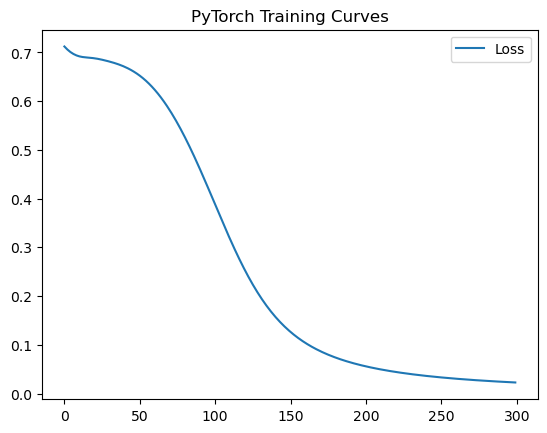

In [31]:
plt.plot(df_pt["Loss"], label="Loss")
plt.title("PyTorch Training Curves")
plt.legend()
plt.show()


In [32]:
print("PyTorch Predictions:")
print(torch.round(model_pt(X_torch)))


PyTorch Predictions:
tensor([[0.],
        [1.],
        [1.],
        [0.]], grad_fn=<RoundBackward0>)


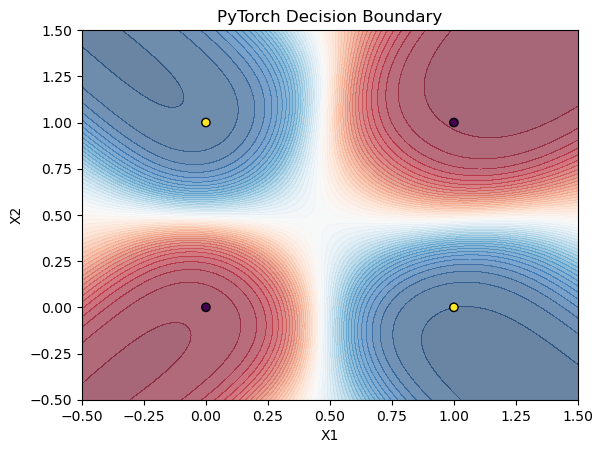

In [33]:
plot_decision_boundary(
    lambda x: model_pt(torch.tensor(x, dtype=torch.float32)).detach().numpy(),
    "PyTorch Decision Boundary"
)


# XOR Using Tensorflow

In [34]:
hidden_neurons = 4

W1 = tf.Variable(tf.random.normal([2, hidden_neurons]))
b1 = tf.Variable(tf.zeros([hidden_neurons]))
W2 = tf.Variable(tf.random.normal([hidden_neurons, 1]))
b2 = tf.Variable(tf.zeros([1]))


In [35]:
def model_tf(X):
    z1 = tf.nn.tanh(tf.matmul(X, W1) + b1)
    z2 = tf.matmul(z1, W2) + b2
    return tf.sigmoid(z2)


In [36]:
optimizer = tf.optimizers.Adam(0.01)
loss_fn = tf.keras.losses.BinaryCrossentropy()

history_tf = []

for epoch in range(300):
    with tf.GradientTape() as tape:
        y_pred = model_tf(X)
        loss = loss_fn(y, y_pred)

    grads = tape.gradient(loss, [W1, b1, W2, b2])
    optimizer.apply_gradients(zip(grads, [W1, b1, W2, b2]))

    acc = tf.reduce_mean(
        tf.cast(tf.equal(tf.cast(y_pred >= 0.5, tf.float32), y), tf.float32)
    ).numpy()

    history_tf.append([epoch+1, loss.numpy(), acc])


In [38]:
df_tf = pd.DataFrame(history_tf, columns=["Epoch", "Loss", "Accuracy"])
print(df_tf)


     Epoch      Loss  Accuracy
0        1  0.767815      0.25
1        2  0.760756      0.50
2        3  0.753797      0.50
3        4  0.746952      0.50
4        5  0.740230      0.50
..     ...       ...       ...
295    296  0.068515      1.00
296    297  0.067979      1.00
297    298  0.067451      1.00
298    299  0.066929      1.00
299    300  0.066414      1.00

[300 rows x 3 columns]


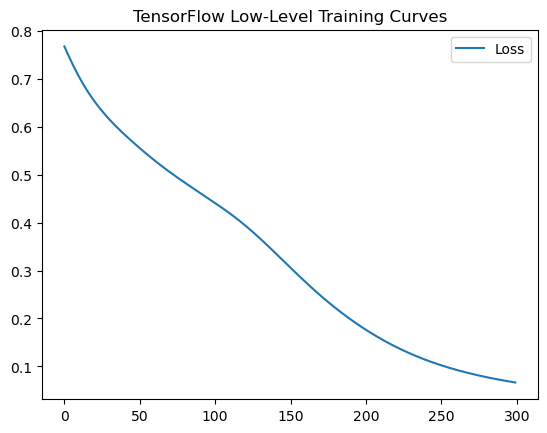

In [41]:
plt.plot(df_tf["Loss"], label="Loss")
plt.title("TensorFlow Low-Level Training Curves")
plt.legend()
plt.show()


In [42]:
print("TensorFlow Predictions:")
print(tf.round(model_tf(X)))


TensorFlow Predictions:
tf.Tensor(
[[0.]
 [1.]
 [1.]
 [0.]], shape=(4, 1), dtype=float32)


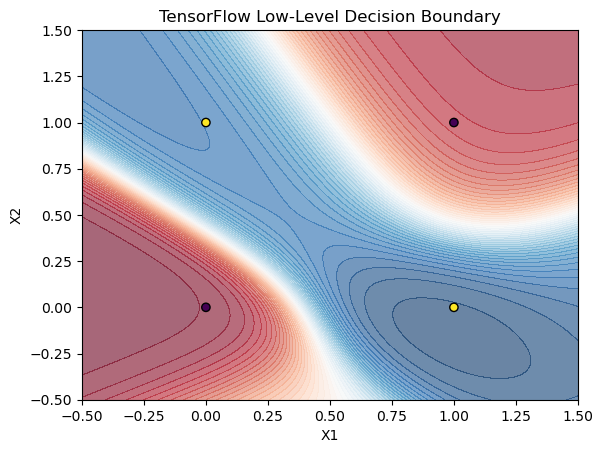

In [43]:
plot_decision_boundary(
    lambda x: model_tf(tf.constant(x, dtype=tf.float32)).numpy(),
    "TensorFlow Low-Level Decision Boundary"
)
